## Хотим найти коэффициенты к каждому этапу

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("/Users/timurkin/Desktop/курсач/данные_проекты.csv")

data_project = df

data_project = data_project[['Тема', 'Baseline PI план','PI (Факт)']]
data_project = data_project.rename(columns={'Baseline PI план': 'TPM', 'PI (Факт)': 'TSM'})
pos = [[5536, 5529, 5524, 5520], [2553, 2548, 2551, 2552, 2550], [2464, 2463, 2462, 2461, 2460]]



##### Функция predict, которая считает предсказание на каждый этап

In [2]:
def predict(data_set, rows):
    current = data_set.iloc[rows]
    current = current.set_index(pd.Index(range(0, len(rows), 1)))

    current['Total spent hours'] = current['TSM']
    for i in range(1, len(rows)):
        current['Total spent hours'][i] = current['Total spent hours'][i-1] + current["TSM"][i]

    current['Total planned hours'] = current['TPM']
    for i in range(1, len(rows)):
        current['Total planned hours'][i] = current['Total planned hours'][i-1] + current["TPM"][i]

    S = pd.to_numeric(current['TSM'][0]) / pd.to_numeric(current['TPM'][0])
    current['Estimate_coef'] = S

    for i in range(1, len(rows)):
        S += pd.to_numeric(current['TSM'][i]) / pd.to_numeric(current['TPM'][i])
        current['Estimate_coef'][i] = S
        current['Estimate_coef'][i] /= i + 1

    S = pd.to_numeric(current['TSM'][0])

    current['Estimate_hours'] = S
    for i in range(1, len(rows)):
        current['Estimate_hours'][i] = pd.to_numeric(current['Estimate_hours'][i-1]) + (pd.to_numeric(current['TPM'][i]) * pd.to_numeric(current['Estimate_coef'][i-1]))
    return current

In [3]:
first = predict(data_project, pos[0])


In [4]:
second = predict(data_project, pos[1])


In [5]:
third = predict(data_project, pos[2])


In [6]:
A = pd.concat([
    first,
    second,
    third
])


#### Хотим подготовить данные для решения линейной регресси, вот так должны они выглядеть

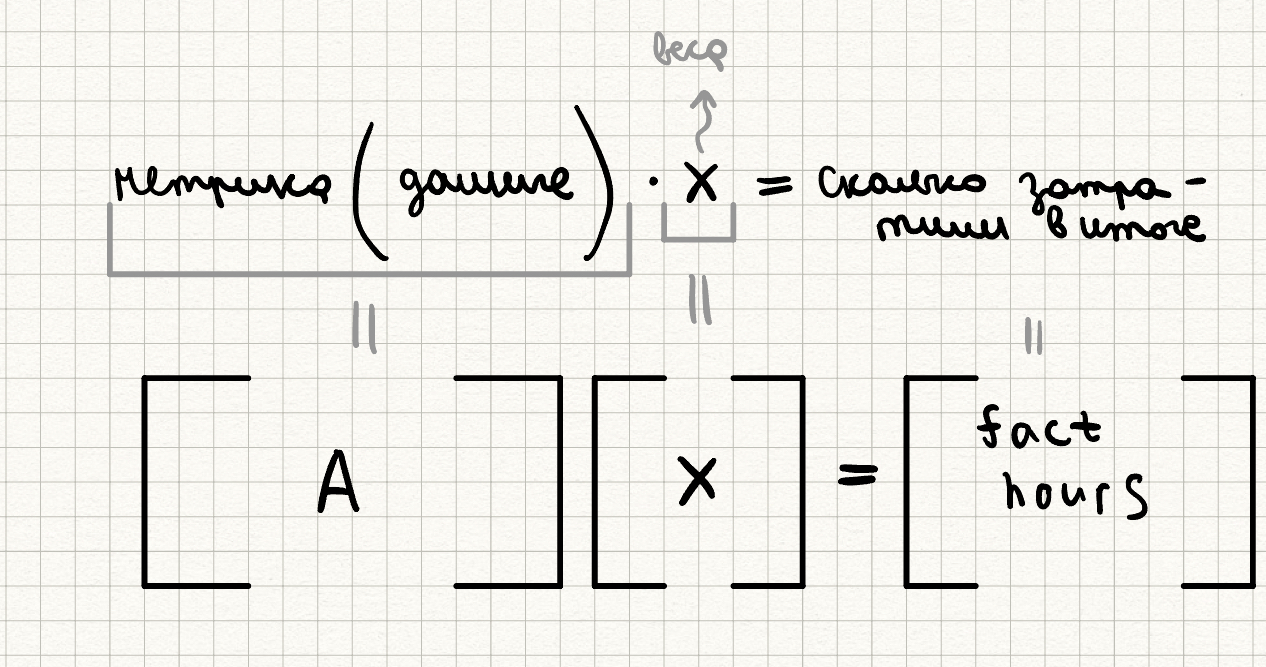

In [7]:
A1 = A.copy()
A1.drop(A1.columns.difference(['Estimate_hours']), axis = 1, inplace = True)
A1

,Estimate_hours
0,36.000000
1,56.635983
2,71.969612
3,119.502639
0,19.000000
1,38.000000
2,44.750000
3,67.683333
4,105.877083
0,7.000000


In [8]:
Y = A.copy()
Y.drop(Y.columns.difference(['Total spent hours']), axis = 1, inplace = True)
Y

,Total spent hours
0,36.0
1,55.0
2,77.0
3,152.0
0,19.0
1,27.0
2,35.0
3,102.0
4,159.0
0,7.0


In [9]:
from sklearn.linear_model import LinearRegression

x = np.array(A1)
y = np.array(Y)


model = LinearRegression().fit(x, y)
score = model.score(x, y)
print('coefficient of determination:', score)
print('intercept:', model.intercept_)

coefficient of determination: 0.9813252471129057
intercept: [47.34536278]


In [10]:
y_pred = model.predict(x)
print('predicted response:', y_pred, sep='\n')

predicted response:
[[  67.29546296]
 [  78.73129445]
 [  87.22872295]
 [ 113.57007473]
 [  57.87458232]
 [  68.40380186]
 [  72.14444565]
 [  84.85339836]
 [ 106.01920777]
 [  51.22454892]
 [ 200.87493007]
 [1269.53578086]
 [1348.07045273]
 [1548.07329636]]


### Итак, получим нужнные коэффициенты

In [11]:
result = y/y_pred
res = pd.DataFrame(result)
res

,0
0,0.534954
1,0.698579
2,0.882737
3,1.338381
4,0.328296
5,0.394715
6,0.485138
7,1.202073
8,1.499728
9,0.136653


#### Теперь получим средние коэффициенты для каждого этапа

In [12]:
initiation = (result[4]+result[9])/2
analysis = (result[0]+result[5]+result[10])/3
realization = (result[1]+result[6]+result[11])/3
introduction = (result[2]+result[7]+result[12])/3
completion = (result[3]+result[8]+result[13])/3
print('коэффициент для этапа инициализация:', *initiation)
print('коэффициент для этапа анализ:', *analysis)
print('коэффициент для этапа реализация:', *realization)
print('коэффициент для этапа внедрение:', *introduction)
print('коэффициент для этапа завершение:', *completion)

коэффициент для этапа инициализация: 0.23247466725616472
коэффициент для этапа анализ: 0.9210494709386791
коэффициент для этапа реализация: 0.692791398374155
коэффициент для этапа внедрение: 1.0176942795195165
коэффициент для этапа завершение: 1.306807356644797


#### Проверим результат коэффициентов для каждого проекта, для этого построим predict-график без коэффициентов и predict-график с коэффициентами

In [13]:
def show_graphics_4(data, ax):
    stages_4 = ['анализ', 'реализация', 'внедрение', 'завершение']

    ax.plot(stages_4, data['Estimate_hours'], label='предсказание')
    ax.plot(stages_4, data['Estimate_hours'], 'ro', label='milestone')
    ax.plot(stages_4, data['Total planned hours'].values, label='план')
    ax.plot(stages_4, data['Total spent hours'].values, label='факт')

    for stage in stages_4:
        ax.axvline(x=stage, linestyle='dashed')

    ax.grid()
    ax.set_xlabel('номер майлстоуна')
    ax.set_ylabel('оценка на часы выполнения')
    ax.legend()


def show_graphics_5(data, ax):
    stages_5 = ['концепция', 'проц. арх.', 'сис. арх.', 'тех. зад.', 'устав']

    ax.plot(stages_5, data['Estimate_hours'], label='предсказание')
    ax.plot(stages_5, data['Estimate_hours'], 'ro', label='milestone')
    ax.plot(stages_5, data['Total planned hours'].values, label='план')
    ax.plot(stages_5, data['Total spent hours'].values, label='факт')
    
    for stage in stages_5:
        ax.axvline(x=stage, linestyle='dashed')
    
    ax.grid()
    ax.set_xlabel('номер майлстоуна')
    ax.set_ylabel('оценка на часы выполнения')
    ax.legend()


### Predict-график без коэффициентов

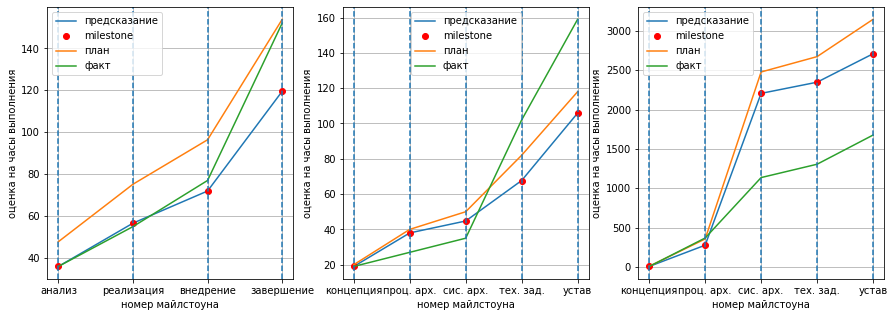

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

show_graphics_4(first, axs[0])
show_graphics_5(second, axs[1])
show_graphics_5(third, axs[2])

### Predict-график с коэффициентами


In [16]:
f_coef = first.copy()
f_coef['Estimate_hours'][0]*=analysis[0]
f_coef['Estimate_hours'][1]*=realization[0]
f_coef['Estimate_hours'][2]*=introduction[0]
f_coef['Estimate_hours'][3]*=completion[0]


In [17]:
s_coef = second.copy()

s_coef['Estimate_hours'][0]*=initiation[0]
s_coef['Estimate_hours'][1]*=analysis[0]
s_coef['Estimate_hours'][2]*=realization[0]
s_coef['Estimate_hours'][3]*=introduction[0]
s_coef['Estimate_hours'][4]*=completion[0]


In [18]:
t_coef = third.copy()

t_coef['Estimate_hours'][0]*=initiation[0]
t_coef['Estimate_hours'][1]*=analysis[0]
t_coef['Estimate_hours'][2]*=realization[0]
t_coef['Estimate_hours'][3]*=introduction[0]
t_coef['Estimate_hours'][4]*=completion[0]



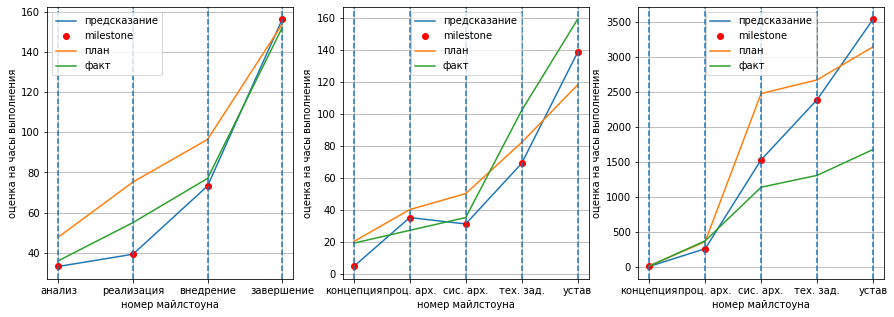

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

show_graphics_4(f_coef, axs[0])
show_graphics_5(s_coef, axs[1])
show_graphics_5(t_coef, axs[2])

### Как видим стало лучше, победа!

In [20]:
print('коэффициент для этапа инициализация:', *initiation)
print('коэффициент для этапа анализ:', *analysis)
print('коэффициент для этапа реализация:', *realization)
print('коэффициент для этапа внедрение:', *introduction)
print('коэффициент для этапа завершение:', *completion)

коэффициент для этапа инициализация: 0.23247466725616472
коэффициент для этапа анализ: 0.9210494709386791
коэффициент для этапа реализация: 0.692791398374155
коэффициент для этапа внедрение: 1.0176942795195165
коэффициент для этапа завершение: 1.306807356644797


## Давайте теперь попробуем сделать графики предикта для каждого из этапов 

Для первого проекта

In [22]:
# пусть прошел только первый этап
import copy
first_first_point = copy.deepcopy(first)
for i in range(1, 4):
    first_first_point["Total spent hours"][i] = None
    first_first_point["TSM"][i] = None
    first_first_point["Estimate_coef"][i] = None
    first_first_point["Estimate_hours"][i] = None


In [24]:
# каждый раз мы обновляем нашу оценку на производительность, усредняя ее
coefs = [*initiation, *analysis, *realization, *introduction, *completion]
begin_coef = first_first_point["Estimate_coef"][0]

first_first_point["Estimate_hours"][0] *= coefs[1]
first_first_point["Estimate_coef"][0] *= coefs[1]

for i in range(1, 4):
    first_first_point["Estimate_hours"][i] = coefs[i + 1] * begin_coef * first_first_point["Total planned hours"][i]

    

In [28]:
def predict_stages(data_set, rows, stage, coefs):
    
    '''
    stage - это номер последнего завершившегося этапа
    stage /in {0, 1, 2, 3, 4} 
    0 - инициация
    1 - анализ
    2 - реализация 
    3 - внедрение
    4 - завершение
    '''
    current = data_set.iloc[rows]
    current = current.set_index(pd.Index(range(0, len(rows), 1)))

    current['Total planned hours'] = current['TPM']
    for i in range(1, len(rows)):
        current['Total planned hours'][i] = current['Total planned hours'][i-1] + current["TPM"][i]

    S = pd.to_numeric(current['TSM'][0]) / pd.to_numeric(current['TPM'][0])
    current['Estimate_coef'] = S
    
    last_index = 1
    for i in range(1, stage):
        if pd.isna(current['TSM'][i]):
            last_index = i
            break
        S += pd.to_numeric(current['TSM'][i]) / pd.to_numeric(current['TPM'][i])
        current['Estimate_coef'][i] = S
        current['Estimate_coef'][i] /= i + 1
        

    for i in range(last_index, len(rows)):
        current['Estimate_coef'][i] = current['Estimate_coef'][stage - 1]
        
        
    if len(rows) == 4:
        for i in range(stage + 1, len(coefs)):
            current['Estimate_coef'][i - 1] *= coefs[i]
    if len(rows) == 5:
        current['Estimate_coef'] * coefs[i]


    current['Estimate_hours'] = 1
    for i in range (0, len(rows)):
        current['Estimate_hours'][i] = current['Estimate_coef'][i] * current['TPM'][i]
    
    return current


In [29]:
first_ff = predict_stages(data_project, pos[0], 1, coefs)


In [30]:
first_second_stage = predict_stages(data_project, pos[0], 2, coefs)


In [31]:
first_third_stage = predict_stages(data_project, pos[0], 3, coefs)


[55.0, 70.0, 124.0]
47.8 75.19999999999999 96.39999999999999 153.79999999999998
36.0 55.0 77.0 152.0
36.0 55.0 70.0 124.0
[[ 47.8  36.   36. ]
 [ 75.2  55.   55. ]
 [ 96.4  77.   70. ]
 [153.8 152.  124. ]]
[77.0, 131.0]


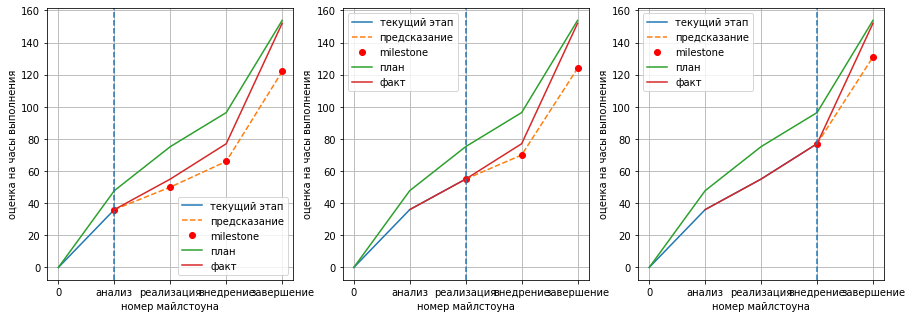

In [38]:
plan = [x for x in first['Total planned hours'].values]
stages_4 = ['анализ', 'реализация', 'внедрение', 'завершение']
st = [0] + stages_4


fig, axs = plt.subplots(1, 3, figsize=(15, 5))


axs[0].plot([0, stages_4[0]], [0, first['TSM'][0]], label='текущий этап')

est = []
s = 0
for x in first_ff['Estimate_hours']:
    s += x
    est.append(s)
real = []
s1 = 0
for x in first['TSM']:
    s1 += x
    real.append(s1)
axs[0].plot(stages_4, est, label='предсказание', linestyle='dashed')
axs[0].plot(stages_4, est, 'ro', label='milestone')
axs[0].plot(st, [0] + plan, label='план')
axs[0].plot(stages_4, real, label='факт')
axs[0].axvline(x=1, linestyle='dashed')
axs[0].grid()
axs[0].set_xlabel('номер майлстоуна')
axs[0].set_ylabel('оценка на часы выполнения')
axs[0].legend()



axs[1].plot([0, stages_4[0], stages_4[1]], [0, first['TSM'][0], first['TSM'][0] + first['TSM'][1]], label='текущий этап')

est = []
s = sum(first['TSM'][0:2])
est.append(s)
for x in first_second_stage['Estimate_hours'][2:]:
    s += x
    est.append(s)
    
real = []
s1 = 0
for x in first['TSM']:
    s1 += x
    real.append(s1)
print(est)

axs[1].plot(['реализация', 'внедрение', 'завершение'], est, label='предсказание', linestyle='dashed')
axs[1].plot(['реализация', 'внедрение', 'завершение'], est, 'ro', label='milestone')
axs[1].plot(st, [0] + plan, label='план')
axs[1].plot(stages_4, real, label='факт')
axs[1].axvline(x=2, linestyle='dashed')
axs[1].grid()
axs[1].set_xlabel('номер майлстоуна')
axs[1].set_ylabel('оценка на часы выполнения')
axs[1].legend()





aaaa = [real[0], *est]

import numpy as np

brrr = np.array([plan, real, aaaa])

print(*(plan)) # план
print(*(real)) # факт
print(*(aaaa)) # предикт

print(brrr.T)


axs[2].plot([0, stages_4[0], stages_4[1], stages_4[2]], [0, first['TSM'][0], first['TSM'][0] + first['TSM'][1], first['TSM'][0] + first['TSM'][1] + first['TSM'][2]], label='текущий этап')

est = []
s = sum(first['TSM'][0:3])
est.append(s)
for x in first_second_stage['Estimate_hours'][3:]:
    s += x
    est.append(s)
    
real = []
s1 = 0
for x in first['TSM']:
    s1 += x
    real.append(s1)
print(est)

axs[2].plot(['внедрение', 'завершение'], est, label='предсказание', linestyle='dashed')
axs[2].plot(['внедрение', 'завершение'], est, 'ro', label='milestone')
axs[2].plot(st, [0] + plan, label='план')
axs[2].plot(stages_4, real, label='факт')
axs[2].axvline(x=3, linestyle='dashed')
axs[2].grid()
axs[2].set_xlabel('номер майлстоуна')
axs[2].set_ylabel('оценка на часы выполнения')
axs[2].legend()



In [33]:
aaaa = [real[0], real[1], *est]

print(*([0] + plan)) # план
print(*real) # факт
print(*aaaa) # предикт

0 47.8 75.19999999999999 96.39999999999999 153.79999999999998
36.0 55.0 77.0 152.0
36.0 55.0 77.0 131.0


### Теперь попробуем найти коэффициенты по-другому, а именно относительно доли каждого этапа в проекте

In [34]:
f_copy = first.copy()
s_copy = second.copy()
t_copy = third.copy()


In [36]:
sum_f = f_copy['Total planned hours'].sum()
sum_s = s_copy['Total planned hours'].sum()
sum_t = t_copy['Total planned hours'].sum()
f_copy['predict_coef'] = f_copy['Total planned hours']/sum_f
f_copy['predict_coef']

0    0.128081
1    0.201501
2    0.258307
3    0.412111
Name: predict_coef, dtype: float64

#### Как видим, коэффициенты получились довольно плохими, так как предсказание по ним является не точным. Мы пришли к выводу: не использовать этот подход